In [20]:
import gym
import Box2D
from Box2D.b2 import (edgeShape, circleShape, fixtureDef, polygonShape, revoluteJointDef, contactListener)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
import random
from collections import namedtuple
import warnings
from tqdm import tqdm_notebook as tqdm
warnings.filterwarnings('ignore')

In [21]:
env = gym.make('LunarLander-v2')

In [22]:
num_state = env.observation_space.shape[0]
num_action = env.action_space.n


In [23]:
class network(nn.Module):
    
    def __init__(self , num_state , num_action):
        
        super().__init__()
        self.fc1 = nn.Linear(num_state ,  16)
        self.fc2 = nn.Linear(16 ,  8)
        # self.fc3 = nn.Linear(8 , 32)
        # self.fc4 = nn.Linear(32 , 64)
        # self.fc5 = nn.Linear(64 , 20)
        self.out = nn.Linear(8 , num_action )
                
    def forward(self , x):
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        # x = F.relu(self.fc5(x))
        x = self.out(x)
        return x

In [24]:
class ReplayBuffer(object):

    def __init__(self, size):

        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_t1, done):

        data = (obs_t, action, reward, obs_t1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes, dtype = np.float32):

        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []

        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False,dtype=dtype))
            actions.append(np.array(action, copy=False,dtype=np.long))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False,dtype=dtype))
            dones.append(done)
        return np.array(obses_t,dtype=dtype), np.array(actions , dtype = np.long), \
            np.array(rewards  ,dtype=dtype), np.array(obses_tp1,dtype=dtype), np.array(dones , dtype = bool)
    
    def sample(self, batch_size):

        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)

In [25]:
class Agent():

    def __init__(self, num_state, num_action):

        self.policy_network = network(num_state, num_action)
        self.target_network = network(num_state, num_action)

        self.target_network.load_state_dict(self.policy_network.state_dict())

        self.steps_done = 0
        self.num_state = num_state
        self.num_action = num_action

        self.EPS_END = 0.05
        self.EPS_START = 0.999
        self.EPS_DECAY = 1000

        self.batch_size = 64
        self.buffer = ReplayBuffer( 4000 )
        self.optimizer = torch.optim.Adam(self.policy_network.parameters(), amsgrad=True)

    def take_action(self, x, is_testing = False):
        eps_thresold = self.EPS_END + (self.EPS_START - self.EPS_END) * \
        math.exp(-1. * self.steps_done / self.EPS_DECAY)

        x = x.astype(np.float32)
        x = torch.from_numpy(x)
        rand_val = np.random.uniform()

        if rand_val > eps_thresold or is_testing == True:
            val = self.policy_network(x)
            action = torch.argmax(val).item()

        else:
            action = np.random.randint(0, self.num_action)

        if is_testing:
            self.steps_done += 1
            
        return action

    def store_transition(self, state, action, reward, next_state, done):

        self.buffer.add(state, action, reward, next_state, done)

    def update_parameters(self):
        
        if len(self.buffer) < self.batch_size:
            return 
        
        loss_fn = torch.nn.MSELoss(reduction = 'mean')
        
        batch = self.buffer.sample(self.batch_size)
        states , actions , rewards , next_states , dones = batch
        states = torch.from_numpy(states)
        actions = torch.from_numpy(actions).view(-1,1)
        rewards = torch.from_numpy(rewards)
        next_states = torch.from_numpy(next_states)
        actions = actions.long()
        
        non_final_mask = torch.tensor(tuple(map(lambda s : s != True, dones)),dtype = torch.bool)
        non_final_next_state = next_states[non_final_mask]
        
  
        pred_q = self.policy_network(states).gather(1 , actions).view(-1) 
        
        
        next_state_value = torch.zeros(self.batch_size).detach()
        next_state_value[non_final_mask] = self.target_network(non_final_next_state).max(1)[0]
        expected_q = (next_state_value + rewards).detach()
        
        
        loss = loss_fn(pred_q , expected_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def update_target_weight(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

In [26]:
def heuristic(env, s):
    """
    The heuristic for
    1. Testing
    2. Demonstration rollout.
    Args:
        env: The environment
        s (list): The state. Attributes:
                  s[0] is the horizontal coordinate
                  s[1] is the vertical coordinate
                  s[2] is the horizontal speed
                  s[3] is the vertical speed
                  s[4] is the angle
                  s[5] is the angular speed
                  s[6] 1 if first leg has contact, else 0
                  s[7] 1 if second leg has contact, else 0
    returns:
         a: The heuristic to be fed into the step function defined above to determine the next step and reward.
    """

    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center
    if angle_targ > 0.4: angle_targ = 0.4    # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5])*1.0
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo*20 - 1, -angle_todo*20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
        elif angle_todo < -0.05: a = 3
        elif angle_todo > +0.05: a = 1
    return a


In [27]:
from PIL import Image
import time
def get_snap_shot(agent  , env_name = 'LunarLander-v2' , gif_filename = None):
    try:
        
        if gif_filename != None:
            frames = []
        
        env = gym.make(env_name)
        state = env.reset()
        done = False
        rew_sum = 0.0
        while done == False:
            if gif_filename != None:
                frames.append(Image.fromarray(env.render(mode='rgb_array')))
            else:
                env.render()
            action = agent.take_action(state , is_testing = True)
            next_state , reward , done , _ = env.step(action)
            rew_sum += reward
            state = next_state[:]
        print('total reward',rew_sum)
        
        if gif_filename != None:
            with open(gif_filename,'wb') as f:
                im = Image.new('RGB', frames[0].size)
                im.save(f, save_all=True, append_images=frames)
        time.sleep(1.5) #Prevent kernel dead
        
    finally:
        env.close()

In [29]:
agent = Agent(num_state , num_action)
reward_history = []
try:
    env = gym.make('LunarLander-v2')
    for e in tqdm(range(601)):
        state = env.reset()
        done = False
        reward_sum = 0.0
        while done == False:
            
            action = agent.take_action(state)
            best_action = heuristic(env, state)
            next_state , reward , done , _ = env.step(action)
            reward_sum += reward
            

            ###  reward shaping  ###

            if reward == -100:
                reward -= 500
            if reward == 100:
                reward += 500

            if next_state[3] < state[3]:
                reward += 0.01
            else:
                reward -= 0.01

            if best_action == action:
                reward += 100

            ###  reward shaping  ###

            agent.store_transition( state , action , reward , next_state , done )
            state = next_state[:]
            agent.update_parameters()
            
        reward_history.append(reward_sum)
        if e  % 50 == 0:
            get_snap_shot(agent = agent , gif_filename='LunarLander-v2/episode_{}.gif'.format(e))
            # get_snap_shot(agent = agent)
        if e > 0 and e % 20 == 0:
            agent.update_target_weight()
finally:
    env.close()

total reward -833.9076852052057
total reward -188.83282031752262
total reward -276.06836917721535
total reward 279.19272185461557
total reward -0.9950651521305645
total reward 43.62856983761361
total reward 253.31288788591252
total reward 37.689133766709205
total reward 289.2729894485602
total reward 294.57799293880475
total reward 274.27106148857365
total reward 239.40534528251317
total reward 275.10241920801155



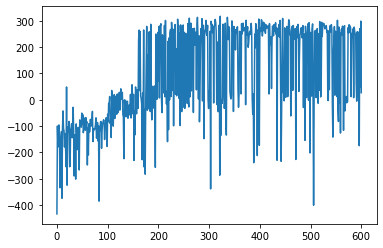

In [41]:
import matplotlib.pyplot as plt
plt.plot(reward_history)